In [90]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [91]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


In [92]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [93]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.rename(columns={"Settle": "Daily_Return"}, inplace=True)
returns

,Daily_Return
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275
...,...
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304


### Lagged Returns 

In [94]:
# Create a lagged return using the shift function
returns['Lagged_Return'] = returns.shift()
returns = returns.dropna()
returns.head()

,Daily_Return,Lagged_Return
Date,,
1990-01-04,1.756933,0.584197
1990-01-05,-0.827626,1.756933
1990-01-08,0.129496,-0.827626
1990-01-09,-0.632275,0.129496
1990-01-10,-0.404917,-0.632275


### Train Test Split

In [95]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = returns[:'2017']
test = returns['2018':]
train

,Daily_Return,Lagged_Return
Date,,
1990-01-04,1.756933,0.584197
1990-01-05,-0.827626,1.756933
1990-01-08,0.129496,-0.827626
1990-01-09,-0.632275,0.129496
1990-01-10,-0.404917,-0.632275
...,...,...
2017-12-22,0.118370,0.084621
2017-12-26,0.118230,0.118370
2017-12-27,-0.151830,0.118230


In [96]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train['Lagged_Return'].to_frame()
X_test = test['Lagged_Return'].to_frame()
y_train = train['Daily_Return']
y_test = test['Daily_Return']

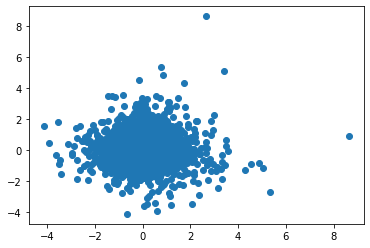

In [97]:
plt.scatter(X_train, y_train)

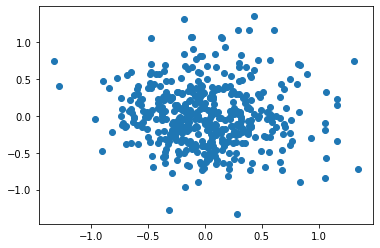

In [98]:
plt.scatter(X_test, y_test)

# Linear Regression Model

In [99]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [100]:
# Make a prediction of "y" values using just the test dataset
predictions_test = model.predict(X_test)

In [101]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results_test = y_test.to_frame()
Results_test["Predicted Return"] = predictions_test

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

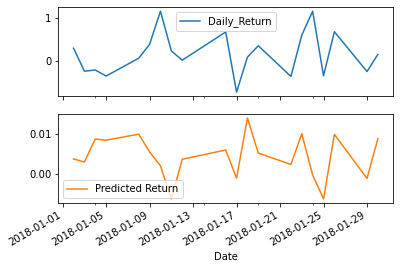

In [102]:
# Plot the first 20 predictions vs the true values
Results_test[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [103]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
from sklearn.metrics import mean_squared_error, r2_score

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
score_test = model.score(X_test, y_test)
r2_test = r2_score(y_test, predictions_test)
mse_test = mean_squared_error(y_test, predictions_test)
rmse_test = np.sqrt(mse_test)

print(f"Score: {score_test}, r2: {r2_test}, rmse: {rmse_test}")

Score: 0.0010352412489498253, r2: 0.0010352412489498253, rmse: 0.4136504970669482


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

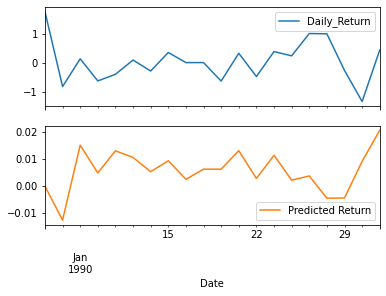

In [104]:
# Construct a dataframe using just the "y" training data:
predictions_train = model.predict(X_train)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results_train = y_train.to_frame()
Results_train["Predicted Return"] = predictions_train

# Plot the first 20 predictions
Results_train[:20].plot(subplots=True)

In [105]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
score_train = model.score(X_train, y_train)
r2_train = r2_score(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
rmse_train = np.sqrt(mse_train)

print(f"Score: {score_train}, r2: {r2_train}, rmse: {rmse_train}")

Score: 0.00011288383707153127, r2: 0.00011288383707153127, rmse: 0.7059387714146014


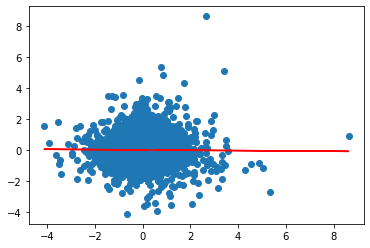

In [106]:
# Plot the regression line for training data. The best fit line is red.
plt.scatter(X_train, y_train)
plt.plot(X_train, predictions_train, color='red')

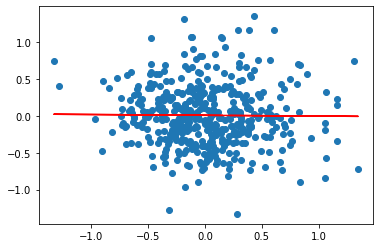

In [107]:
# Plot the regression line for training data. The best fit line is red.
plt.scatter(X_test, y_test)
plt.plot(X_test, predictions_test, color='red')

# Conclusions

YOUR CONCLUSIONS HERE!

See README file